In [109]:
import copy
import glob
import json
import os

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import pandas as pd
import pickle
import statistics
import utm

# local .json file with local path info
geladas_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(geladas_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])


import koger_general_functions as kgf
import mapping_functions as kmap
from drone_movement import create_gt_segment_dicts

# plt.style.use('dark_background')

In [87]:
def load_dsm(dsm_file, dtm=None, subtract_dtm=False):
    dsm_gtif = gdal.Open(dsm_file)

    dsm = dsm_gtif.GetRasterBand(1).ReadAsArray()
    dsm_min = np.min(dsm[dsm != -10000])
    dsm = np.where(dsm == -10000, dsm_min, dsm)
    if subtract_dtm:
        dsm = dsm - dtm
        dsm = np.where(dsm < 0, 0, dsm)
    return dsm


In [88]:
def create_rgb_dsm(dsm, cmap, lowwer_bias=0, upper_bias=0, dsm_mask=None):
    """lowwer_bias: meters, subtract from min evevation in map"""
    if dsm_mask is not None:
        masked_dsm = np.where(dsm_mask, dsm, 0)
    else:
        masked_dsm = dsm
    dsm = dsm - masked_dsm.min() - lowwer_bias
    dsm = dsm / (masked_dsm.max() - upper_bias)
    
    rgb_dsm = cmap(dsm)[..., :3]
    rgb_dsm = (rgb_dsm*255).astype(np.uint8)
    
    return rgb_dsm

In [89]:
observation_name = "DJI_0205"
# Project name assosiated with the saved pix4d files
pix4d_project_name = "gelada_worked_example_DJI_0205"

In [90]:
pix4d_folder = os.path.join(local_paths["pix4d_folder"], observation_name)
pix4d_info = kmap.get_pix4d_info(pix4d_folder, pix4d_project_name, 
                                 load_ortho=True, pmatrix_sort='simple')
utm_tracks_file = os.path.join(pix4d_folder, 'utm_tracks.npy')
utm_tracks = np.load(utm_tracks_file)

In [91]:
dsm_file = os.path.join(pix4d_folder, "3_dsm_ortho", "1_dsm",
                              f"{pix4d_project_name}_dsm.tif") 
dsm = load_dsm(dsm_file, dtm=pix4d_info['elevation_r'], subtract_dtm=True)

In [92]:
deg = u'\N{DEGREE SIGN}'
print(deg)

°


Text(0, 0.5, 'latitude')

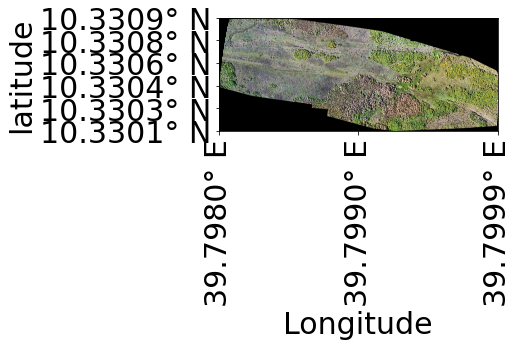

In [93]:
deg = u'\N{DEGREE SIGN}'

use_dms = False

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(pix4d_info['ortho'])

map_shape = pix4d_info['ortho'].shape

x_min = pix4d_info['x_origin']
y_min = pix4d_info['y_origin']
x_max = (x_min + (pix4d_info['pixel_width'] * (map_shape[1])))
y_max = (y_min + (pix4d_info['pixel_height'] * (map_shape[0])))

num_x_ticks = 3
ax.set_xticks(np.linspace(0, map_shape[1], num_x_ticks, dtype=int))
x_labels = np.linspace(x_min, np.abs(x_max), num_x_ticks, dtype=int)
_, lons = utm.to_latlon(x_labels, np.ones(num_x_ticks)*y_min, 37, 'N')
if use_dms:
    lons = [dd2dms(l) for l in lons]
    lons = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" E" for l in lons]
else:
    lons = [f"{l:2.4f}{deg} E" for l in lons]
_ = ax.set_xticklabels(lons, rotation="vertical")
ax.set_xlabel('Longitude')

num_y_ticks = 6
ax.set_yticks(np.linspace(0, map_shape[0], num_y_ticks, dtype=int))
y_labels = np.linspace(y_min, y_max, num_y_ticks, dtype=int)
lats, _ = utm.to_latlon(np.ones(num_y_ticks)*x_min, y_labels, 37, 'N')
if use_dms:
    lats = [dd2dms(l) for l in lats]
    lats = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" N" for l in lats]
else:
    lats = [f"{l:2.4f}{deg} N" for l in lats]
_ = ax.set_yticklabels(lats)
ax.set_ylabel('latitude')

In [96]:
r_dsm = dsm
r_ortho = pix4d_info['ortho']

In [97]:
scale = 1.0

s_dsm = cv2.resize(r_dsm, None, fx=scale, fy=scale)
s_ortho = cv2.resize(r_ortho, None, fx=scale, fy=scale)

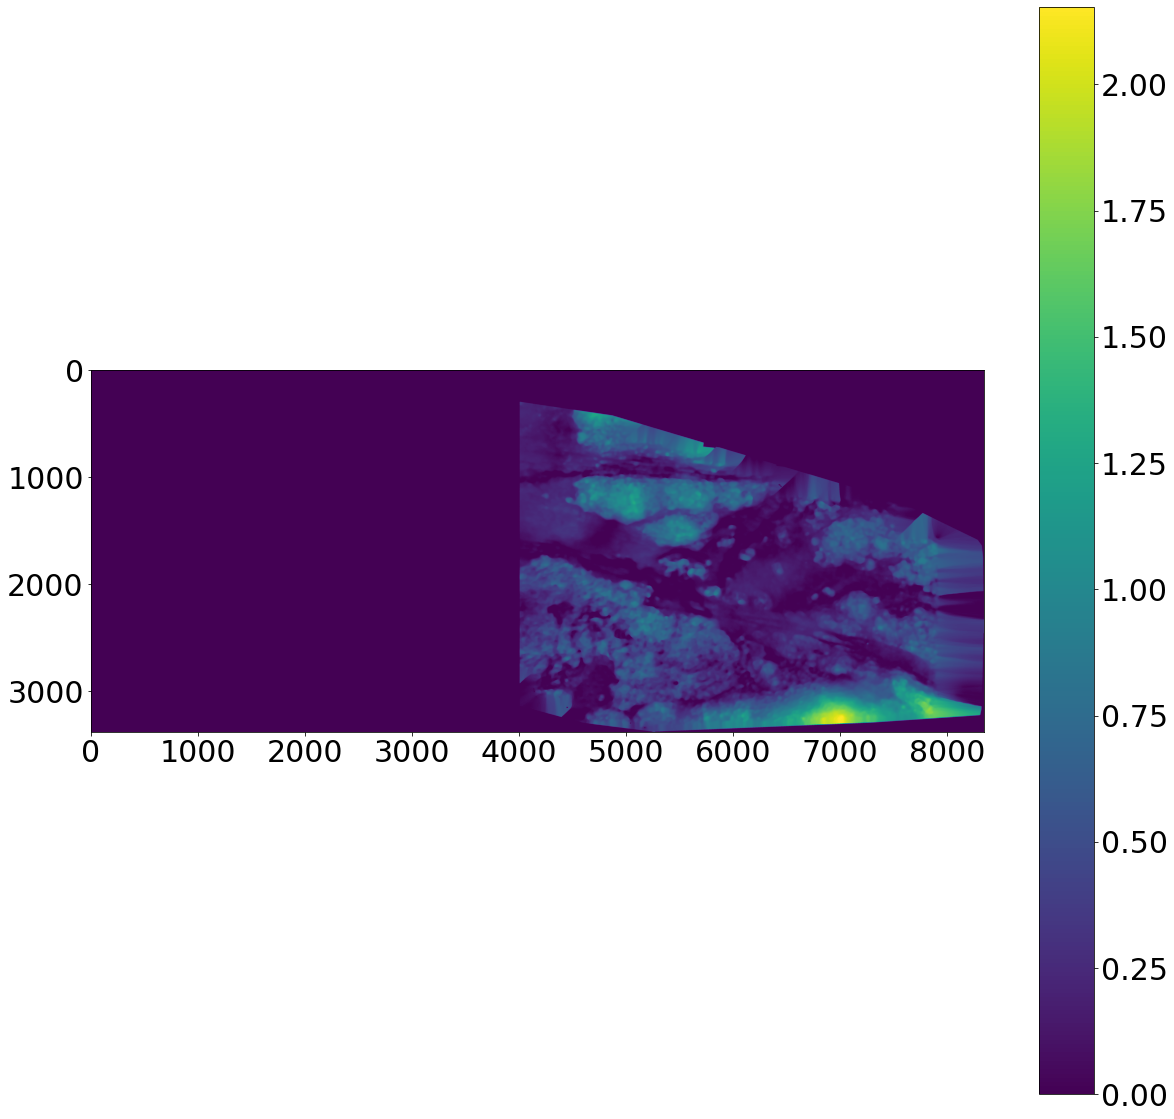

In [98]:
mask = np.where(s_ortho[...,0]==0, 0, 1)
mask[:, :int(4000*scale)] = 0
mask = mask.astype(np.uint8)
# Remove edge of map where elevation error high when choosing max height values
# for visualizations
kernel = np.ones((int(10*scale), int(10*scale)), np.uint8)
eroded_mask = cv2.erode(mask, kernel) 
masked_dsm = np.where(eroded_mask, s_dsm, 0)
height_max = masked_dsm.max() 
plt.figure(figsize=(20,20))
plt.imshow(masked_dsm)
plt.colorbar()

In [99]:
cmap = plt.cm.YlGn
cmap = plt.cm.Greens
cmap = plt.cm.viridis
rgb_dsm = create_rgb_dsm(s_dsm, cmap=cmap, dsm_mask=eroded_mask.astype(bool))

In [100]:
start_fade = int(3000 * scale)
end_fade = int(6000 * scale)
alphas = np.ones_like(s_dsm)
alphas[:, :start_fade] = 0
alphas[:, start_fade:end_fade] *= np.linspace(0, 1.0, (end_fade-start_fade))
alphas[:, end_fade:] = 1
alphas = np.log2(alphas+1)
alphas = np.expand_dims(alphas, axis=2)
alphas = np.repeat(alphas, 3, 2)
merge_landscape = (alphas * rgb_dsm + (1-alphas) * s_ortho).astype(np.uint8)
merge_landscape = np.where(s_ortho==0, s_ortho, merge_landscape)

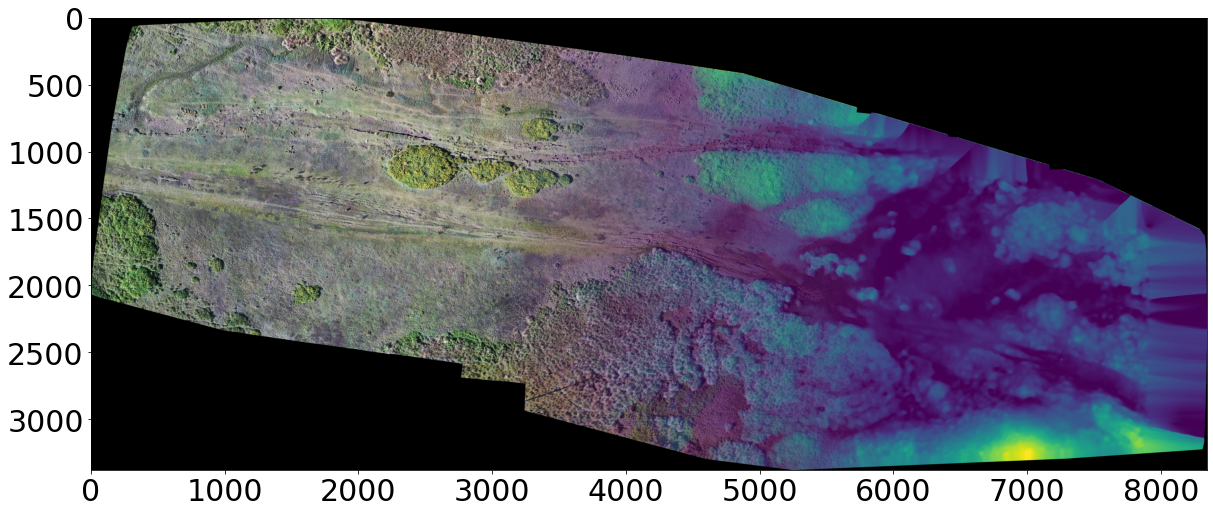

In [101]:
plt.figure(figsize=(20,20))
plt.imshow(merge_landscape)

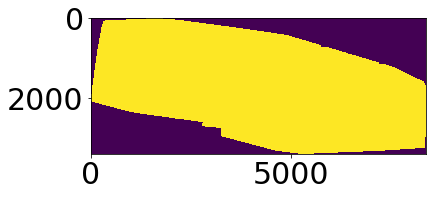

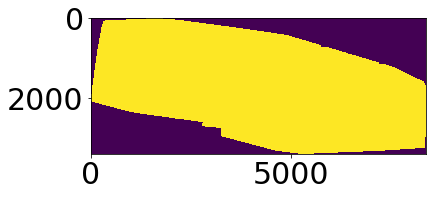

In [102]:
s_ortho = cv2.resize(r_ortho, None, fx=scale, fy=scale)
background_mask = np.where(s_ortho[...,0]==0, 0, 1)
background_mask = background_mask.astype(np.uint8)
plt.imshow(background_mask, interpolation='nearest')
contours, hierarchy = cv2.findContours(background_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
max_area = 0
max_ind = 0
for ind, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if area > max_area:
        max_area = area
        max_ind = ind
cv2.drawContours(background_mask, contours, max_ind, 2, -1)
plt.figure()
plt.imshow(background_mask*100, interpolation='nearest')

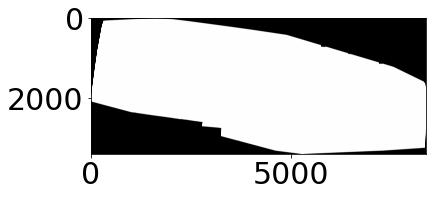

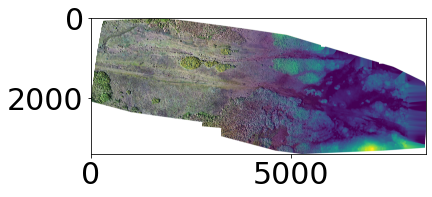

In [103]:

kernel = np.ones((int(100*scale), int(30*scale)), np.uint8)
# background_mask = cv2.dilate(background_mask, kernel) 

mask_3d = np.stack([background_mask, background_mask, background_mask], axis=2)
plt.imshow(mask_3d*255)

merge_landscape = np.where(mask_3d==0, 255, merge_landscape)
plt.figure()
plt.imshow(merge_landscape)

In [104]:
SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [105]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [106]:
def dd2dms(deg):
    # from https://en.proft.me/2015/09/20/converting-latitude-and-longitude-decimal-values-p/
    d = int(deg)
    md = (deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

In [107]:
lat, lon = utm.to_latlon(340000, 5710000, 37, 'N')
dd2dms(lat)

[51, 31, 6.3465815116154545]

In [110]:
def get_tracks_class(track, detections_dicts):
    """Assumes track has keys 'first_frame' """
    track_class = []
    for ind, det_num in enumerate(track['pos_index']):
        if np.isnan(det_num):
            continue
        obs_ind = track['first_frame'] + ind
        pred_class = detections_dicts[obs_ind]['pred_classes'][int(det_num)]
        track_class.append(pred_class)
    return np.array(track_class)

tracks_name = "tracks-complete.npy"
base_folder = os.path.join(local_paths['base_gelada'], "processing", video_name)
tracks_file = os.path.join(local_paths['base_gelada'], "processing", 
                           observation_name, tracks_name)
tracks = np.load(tracks_file, allow_pickle=True)
# list of dicts that contains keys "pred_boxes", "scores", "pred_classes", 
# "image_name" for each frame
detections_file = os.path.join(base_folder, f"{video_name}_detections.npy")
detections_dicts = np.load(detections_file, allow_pickle=True)

track_classes = []
for track in tracks:
    track_class = statistics.mode(get_tracks_class(track, detections_dicts))
    track_classes.append(track_class)

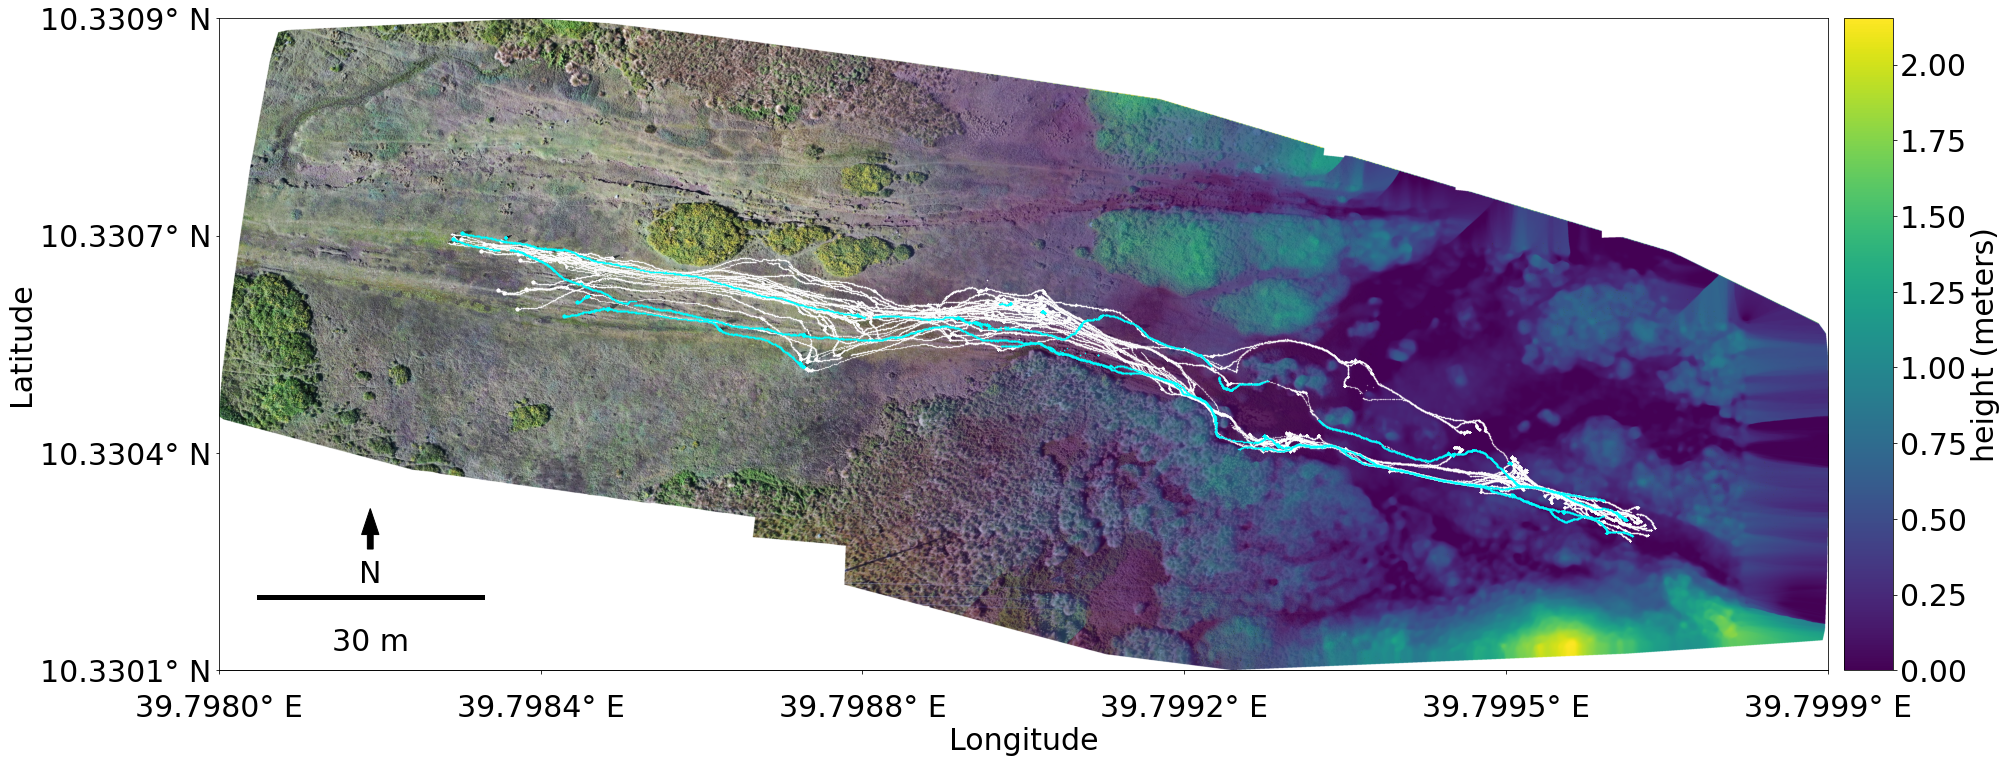

In [111]:
track_ind1 = 0
track_ind2 = 3

save_fig = False

color2 = 'gold'
color1 = 'magenta'

font_color = 'k'

size = 10

use_dms = False # Use degree minute second ticks

# plt.style.use('dark_background')


fig, ax = plt.subplots(figsize=(30, 15))

merge_landscape

ax.imshow(merge_landscape)

# Trails
# ax.imshow(trail_probs, alpha=trail_alpha)

thickness = [.1 for _ in utm_tracks]
thickness[track_ind1] =.1
thickness[track_ind2] = .1
for utm_track, t_class, s in zip(utm_tracks, track_classes, thickness):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info)
    if t_class == 0:
        color = 'cyan'
        alpha = 1.0
    elif t_class == 1:
        color = 'white'
        alpha = .6
    ax.scatter((raster_track[:, 0]*scale), 
               raster_track[:, 1]*scale, 
                s=s, c=color, alpha=alpha)
    
for utm_track, t_class, s in zip(utm_tracks, track_classes, thickness):
    raster_track = kmap.utm_to_raster_track(utm_track, pix4d_info)
    if t_class == 0:
        color = 'cyan'
        alpha = 1.0
    elif t_class == 1:
        color = 'white'
        alpha = 0.0
    ax.scatter((raster_track[:, 0]*scale), 
               raster_track[:, 1]*scale,  
                s=s, c=color, alpha=alpha)
    ax.scatter((raster_track[:1, 0]*scale), 
               raster_track[:1, 1]*scale,  
                s=s*100, c=color, alpha=1.0)
    ax.scatter((raster_track[:1, 0]*scale), 
               raster_track[:1, 1]*scale,  
                s=s*100, c=color, alpha=1.0, marker="*")

# Add utm axis labels
show_axis = True
show_latlon = True
if show_axis:
    x_min = pix4d_info['x_origin']
    y_min = pix4d_info['y_origin']
    x_max = (x_min
                + (pix4d_info['pixel_width'] * (pix4d_info['elevation_r'].shape[1])))
    y_max = (y_min
                + (pix4d_info['pixel_height'] * (pix4d_info['elevation_r'].shape[0])))

    num_x_ticks = 6
    secax = ax.secondary_xaxis('bottom')
    secax.set_xticks(np.linspace(0, s_dsm.shape[1]-1, num_x_ticks, dtype=int))
    # Flipped, so on figure x is northing
    x_labels = np.linspace(x_min, x_max, num_x_ticks, dtype=int)
    if show_latlon:
        _, lons = utm.to_latlon(x_labels, np.ones(num_x_ticks)*y_min, 37, 'P')
        if use_dms:
            lons = [dd2dms(l) for l in lons]
            lons = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" E" for l in lons]
        else:
            lons = [f"{l:2.4f}{deg} E" for l in lons]
        x_labels = lons
        secax.set_xlabel('Longitude')
    else:
        secax.set_xlabel('Meters')
    _ = secax.set_xticklabels(x_labels)
    ax.get_xaxis().set_visible(False)
    # secax.xaxis.tick_top()

    num_y_ticks = 4
    ax.set_yticks(np.linspace(0, s_dsm.shape[0]-1, num_y_ticks))
    # x_max and x_min order flipped because origin of ortho is bottomleft after
    # counter clockwise rotation
    y_labels = np.linspace(y_min, y_max, num_y_ticks, dtype=int)
    if show_latlon:
        lats, _ = utm.to_latlon(np.ones(num_y_ticks)*x_min, y_labels, 37, 'P')
        if use_dms:
            lats = [dd2dms(l) for l in lats]
            lats = [f"{l[0]}{deg} {l[1]}' {l[2]:2.1f}\" N" for l in lats]
        else:
            lats = [f"{l:2.4f}{deg} N" for l in lats]
        y_labels = lats
        ax.set_ylabel('Latitude')
    else:
        ax.set_ylabel('Meters')
    _ = ax.set_yticklabels(y_labels, rotation="horizontal")
    
    secax.tick_params(axis='x', which='major', pad=20)
else:
    ax.axis('off')
    
ax.set_aspect('equal')

# Add colorbar
ax_divider = make_axes_locatable(ax)
# add an axes to the right of the main axes.
cax = ax_divider.append_axes("right", size="3%", pad="1%")
norm = mpl.colors.Normalize(vmin=0, vmax=height_max)

cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb.set_label('height (meters)')

# Add scale bar
line_width = 5 * scale
text_size = 30 * scale
text_buffer = int(200 * scale)

bar_length_meters = 30
bar_length_pixels = bar_length_meters / pix4d_info['pixel_width'] * scale
bar_y_loc = 3000 * scale
bar_x_start = 200 * scale 
bar_x_end = bar_x_start + bar_length_pixels

ax.hlines(bar_y_loc, bar_x_start, bar_x_end, color=font_color, linewidth=line_width,
           antialiased=False)
text_x_loc = int((bar_x_start + bar_x_end) / 2) 
text_y_loc = int(bar_y_loc + line_width + text_size + text_buffer)
# text_y_loc = bar_y_loc
txt = ax.text(text_x_loc, text_y_loc, f"{bar_length_meters} m", 
              size=text_size, ha="center", va='center', color=font_color)

# Add compass
arrow_length = int(100*scale)

ax.arrow(text_x_loc, bar_y_loc-arrow_length-150, 0, -arrow_length*.75, 
         width=30*scale, color=font_color)
txt = ax.text(text_x_loc, bar_y_loc-120*scale, f"N", 
              size=text_size, ha="center", va='center', color=font_color)

file = os.path.join(local_paths['figure_folder'], 
                    f"tracks_on_map_{observation_name}_dsm_fade_latlon_alt_color.png")
if save_fig:
    fig.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight')

### Uncorected tracks

In [112]:
tracks_name = "tracks-complete.npy"

tracks_file = os.path.join(local_paths['base_gelada'], "processing", 
                           observation_name, tracks_name)
tracks = np.load(tracks_file, allow_pickle=True)

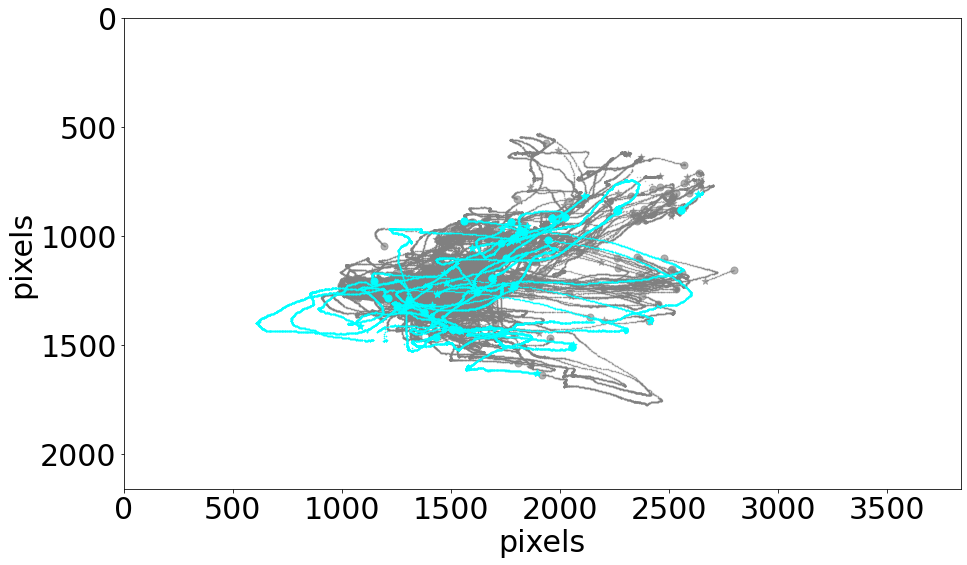

In [114]:
# plt.style.use('dark_background')

thickness = [.2 for _ in utm_tracks]
thickness[track_ind1] =.4
thickness[track_ind2] = .4

plt.figure(figsize=(15, 15))
frame_shape = (2160, 3840, 3)
plt.imshow(np.ones((frame_shape[0], frame_shape[1], 3)))

for track, t_class, s in zip(tracks, track_classes, thickness):
    if t_class == 0:
        color = 'cyan'
        alpha = 1.0
    elif t_class == 1:
        color = 'gray'
        alpha = .6

    track = track['track']
    plt.scatter(track[:, 1], track[:, 0], c=color, alpha=alpha, s=s)
    plt.scatter(track[0, 1], track[0, 0], c=color, alpha=alpha, 
                 s=50)
    plt.scatter(track[-1, 1], track[-1, 0], c=color, alpha=alpha, 
                marker="*", s=50)
    
for track, t_class, s in zip(tracks, track_classes, thickness):
    if t_class == 0:
        color = 'cyan'
        alpha = 1.0
    elif t_class == 1:
        color = 'gray'
        alpha = 0.0
        
    track = track['track']
    plt.scatter(track[:, 1], track[:, 0], c=color, alpha=alpha, s=s)
    plt.scatter(track[0, 1], track[0, 0], c=color, alpha=alpha, 
                 s=50)
    plt.scatter(track[-1, 1], track[-1, 0], c=color, alpha=alpha, 
                marker="*", s=50)
    
plt.gca().set_aspect('equal')
plt.xlabel('pixels')
plt.ylabel('pixels')

file = os.path.join(local_paths['figure_folder'], 
                    f"tracks_in_frame_{observation_name}_alt_color.png")

if save_fig:
    plt.savefig(file, format=None, metadata=None, dpi=300, bbox_inches='tight',
               transparent=True)